In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/stop-words/stopwords.csv


In [79]:
!pip install pyspellchecker
!pip install contractions
!pip install nlpre

In [80]:
import re
import unicodedata
import contractions
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

#NLTK
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, RidgeClassifier, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,GRU
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model

# Word2vec
import gensim

#BERT
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

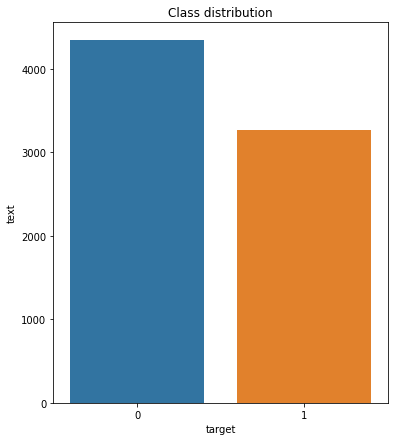

In [81]:
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
df=train_tweets.groupby(['target']).count()

plt.figure(figsize=(6,7))
sns.barplot(x=df.index, y=df.text)
plt.title('Class distribution')
plt.show()

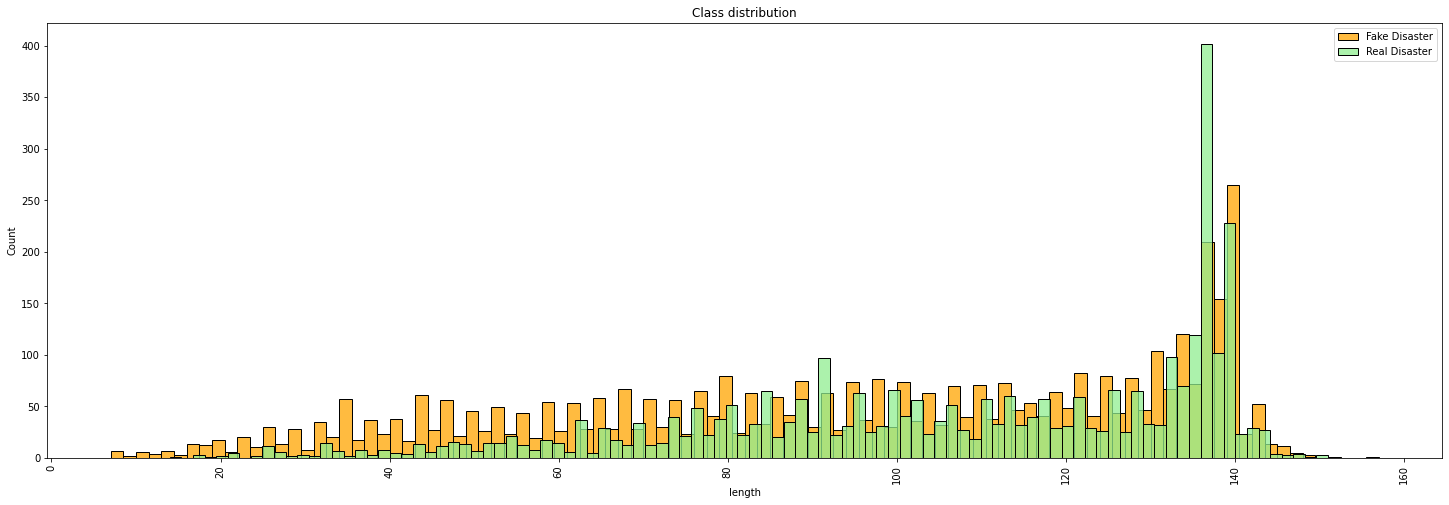

In [82]:
#Looking at class distribution of fake and real disaster tweets
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
train_tweets['length']=[len(i) for i in train_tweets['text']]
df=train_tweets

plt.figure(figsize=(25,8))
ax1=sns.histplot(data=df[df['target']==0]['length'],color='orange',bins=100)
ax2=sns.histplot(data=df[df['target']==1]['length'],color='lightgreen',bins=100)
ax1.legend(['Fake Disaster','Real Disaster'])
plt.xticks(rotation=90)
plt.title('Class distribution')
plt.show()

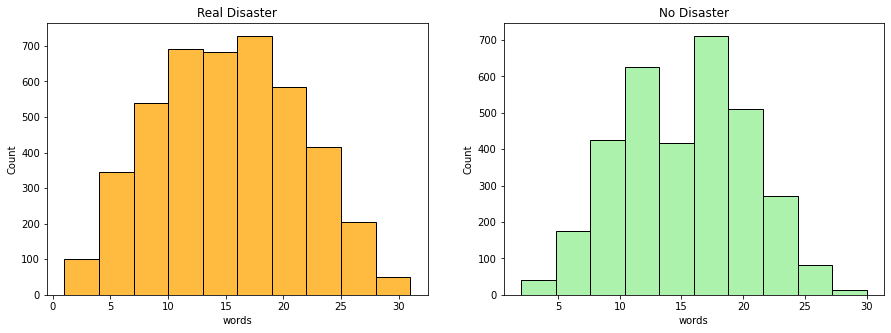

In [83]:
#Histogram plot of Word length distribution
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
train_tweets['words']=[len(i.split()) for i in train_tweets['text']]
df=train_tweets

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.histplot(data=df[df['target']==0]['words'],color='orange',bins=10,ax=ax1).set_title('Real Disaster')
sns.histplot(data=df[df['target']==1]['words'],color='lightgreen',bins=10,ax=ax2).set_title('No Disaster')
plt.show()

In [84]:
#Loading list of stop words
stop_words=pd.read_csv('../input/stop-words/stopwords.csv',names=['stopword'])
stop_words=stop_words.iloc[:,0].values.tolist()

#Function to corpus of stop words present in the data
def stopwords_top(train_tweets,target):
    corpus=[]
    for i in train_tweets[train_tweets['target']==target]['text']:
        for j in i.split():
            if j in stop_words:
                corpus.append(j)
    corpus=pd.DataFrame(corpus,columns=['corpus'])
    corpus=corpus.groupby('corpus')['corpus'].agg(['count'])
    corpus=corpus.sort_values(by='count',ascending=False)[0:10]
    return corpus

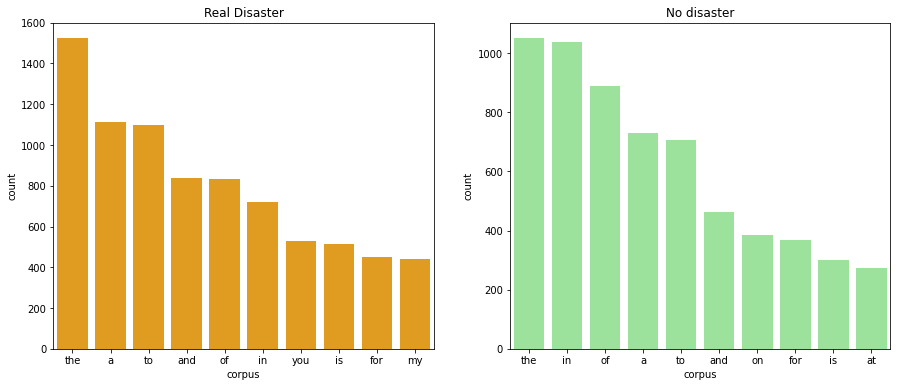

In [85]:

train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
corpus_0=stopwords_top(train_tweets,0)
corpus_1=stopwords_top(train_tweets,1)

#Bar plot of top stop words in the data
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.barplot(x=corpus_0.index,y="count",data=corpus_0,color='orange',ax=ax1).set_title('Real Disaster')
sns.barplot(x=corpus_1.index,y="count",data=corpus_1,color='lightgreen',ax=ax2).set_title('No disaster')
plt.show()

In [86]:
import string
string.punctuation

#Function to create a list of top punctuations
def punctuations_top(train_tweets,target):
    corpus=[]
    for i in train_tweets[train_tweets['target']==target]['text']:
        for j in i.split():
            if j in string.punctuation:
                corpus.append(j)
    corpus=pd.DataFrame(corpus,columns=['corpus'])
    corpus=corpus.groupby('corpus')['corpus'].agg(['count'])
    corpus=corpus.sort_values(by='count',ascending=False)[0:10]
    return corpus

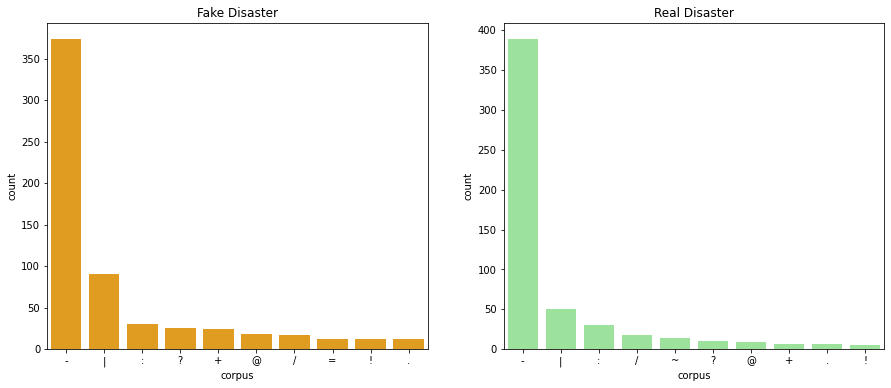

In [87]:
#Bar plot of top punctuations

train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
corpus_0=punctuations_top(train_tweets,0)
corpus_1=punctuations_top(train_tweets,1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.barplot(x=corpus_0.index,y="count",data=corpus_0,color='orange',ax=ax1).set_title('Fake Disaster')
sns.barplot(x=corpus_1.index,y="count",data=corpus_1,color='lightgreen',ax=ax2).set_title('Real Disaster')
plt.show()

In [88]:
#Function to create a count list of top bigram words

def bigram_count(train_tweets):
    vectorizer = CountVectorizer(ngram_range=(2,2))
    bow=vectorizer.fit_transform(train_tweets['text']).todense()
    count_words=np.sum(bow,axis=0)
    bigram=pd.DataFrame(count_words.reshape(-1,1),index=vectorizer.get_feature_names(),columns=['count'])
    bigram=bigram.sort_values(by='count',ascending=False)[0:10]
    return bigram

Text(0.5, 1.0, 'Top 10 Bigram words')

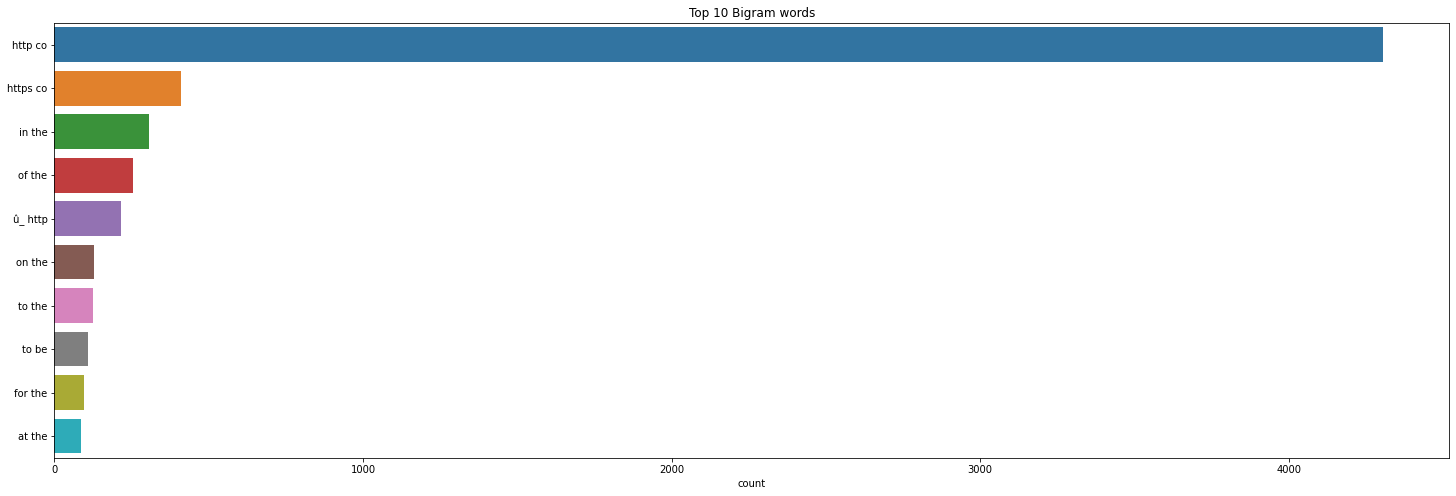

In [89]:
#Bar plot of top bigram words pairs

train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
bigram=bigram_count(train_tweets)
plt.figure(figsize=(25,8))
sns.barplot(y=bigram.index,x="count",data=bigram).set_title('Top 10 Bigram words')

In [90]:
#Function to create a count list of top trigram words

def trigram_count(train_tweets):
    vectorizer = CountVectorizer(ngram_range=(3,3))
    bow=vectorizer.fit_transform(train_tweets['text']).todense()
    count_words=np.sum(bow,axis=0)
    trigram=pd.DataFrame(count_words.reshape(-1,1),index=vectorizer.get_feature_names(),columns=['count'])
    trigram=trigram.sort_values(by='count',ascending=False)[0:10]
    return trigram

Text(0.5, 1.0, 'Top 10 Trigram words')

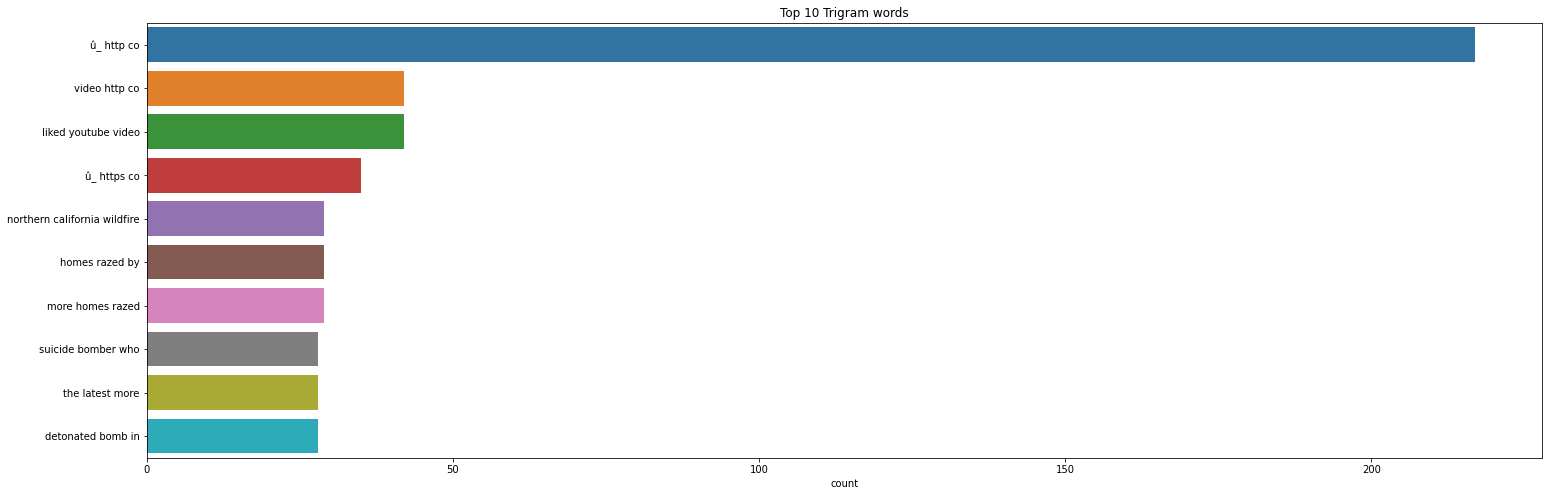

In [91]:
#Bar plot of top trigram words

train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
trigram=trigram_count(train_tweets)
plt.figure(figsize=(25,8))
sns.barplot(y=trigram.index,x="count",data=trigram).set_title('Top 10 Trigram words')

In [92]:
def preProcessTweets(tweet_dataframe):

    stop_words=pd.read_csv('../input/stop-words/stopwords.csv',names=['stopword'])
    stop_words=stop_words.iloc[:,0].values.tolist()
    spell = SpellChecker(language='en',distance=1)
    
    #Seperating out tweets from the data
    tweet=tweet_dataframe['text']#.values

    #Using Regex functions to remove hyperlinks and non-essential characters
    t1=[]
    for i in range(len(tweet)):
        t1.append(re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',str(tweet[i])))
    for i in range(len(t1)):
        t1[i]=re.sub('[^a-zA-Z]+',' ',str(t1[i]))
    for i in range(len(t1)):
        t1[i] = ' '.join(word for word in t1[i].split() if word not in stop_words)
        t1[i]=t1[i].lower()
        t1[i] = contractions.fix(t1[i])
        t1[i]= spell.correction(t1[i])
        t1[i]=' '.join(word for word in t1[i].split() if len(word)>3)
        
    corpus_stemmed = []
    
    #Lementing words
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    for d in t1:
        words = pd.Series(wordpunct_tokenize(d),dtype='object')
        stemmed_words = words.apply(wordnet_lemmatizer.lemmatize)
        corpus_stemmed.append(' '.join(list(stemmed_words)))
    
    return corpus_stemmed

In [93]:
#Preprocessing for Wordcloud
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
train_tweets['clean_text']=preProcessTweets(train_tweets)

#Removing words with length less than 3
train_tweets['clean_text']=train_tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

(-0.5, 799.5, 499.5, -0.5)

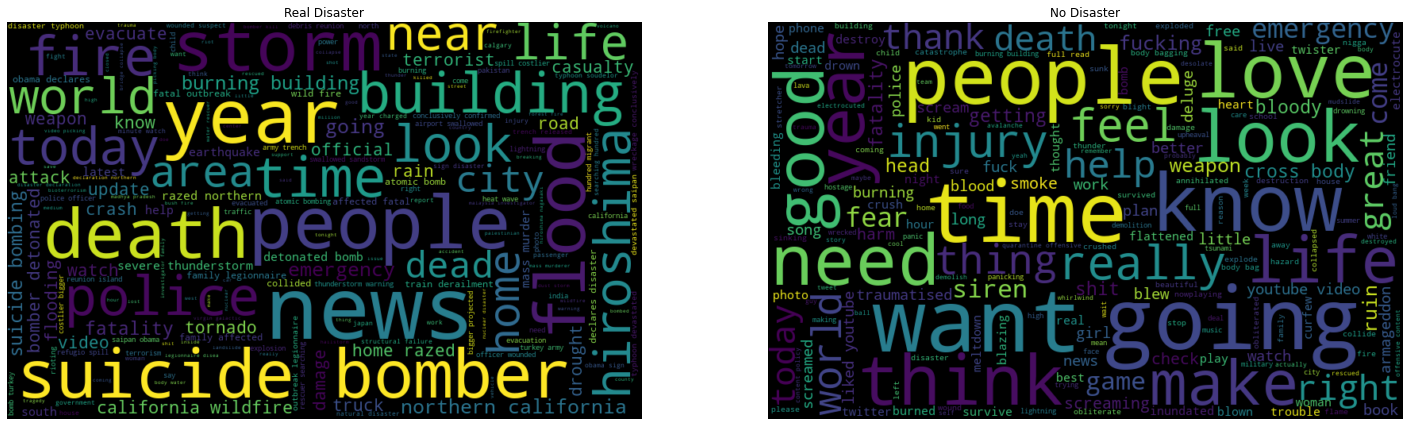

In [94]:
from wordcloud import WordCloud 

train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')

#Preprocessing for Wordcloud
train_tweets['clean_text']=preProcessTweets(train_tweets)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10))

#Wordcloud for real disaster tweets
all_word = ' '.join([text for text in train_tweets[train_tweets['target']==1]['clean_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
#ax1=plt.figure(figsize=(10, 7)) 
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.set_title('Real Disaster')
ax1.axis('off')

#Wordcloud for non disaster tweets
all_word = ' '.join([text for text in train_tweets[train_tweets['target']==0]['clean_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
#ax2=plt.figure(figsize=(10, 7)) 
ax2.imshow(wordcloud, interpolation="bilinear")
ax2.set_title('No Disaster')
ax2.axis('off')


In [95]:
#TDIDF
def tfidf(train_tweets,test_tweets,ngram=(1, 1)):
    
    tfidf_transformer=TfidfVectorizer(ngram_range=ngram)#stop_words="english")#ngram_range=(1, 2),stop_words="english")#,ngram_range=(1, 2))

    x_train=preProcessTweets(train_tweets)
    x_train=tfidf_transformer.fit_transform(x_train).todense()
    y_train = train_tweets['target'].values

    x_test=preProcessTweets(test_tweets)
    x_test=tfidf_transformer.transform(x_test).todense()
    
    return x_train,y_train,x_test

In [96]:
#CountVectorizer
def countVect(train_tweets,test_tweets,ngram=(1, 1)):
    # Instantiating a vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram)#stop_words="english")#token_pattern=r"(?u)\b\w[\w'’]*\w\b")#stop_words="english", )

    # Creating a raw term frequency matrix
    x_train=preProcessTweets(train_tweets)
    x_train = np.asarray(vectorizer.fit_transform(x_train).todense())
    y_train = train_tweets['target'].values

    x_test=preProcessTweets(test_tweets)
    x_test = np.asarray(vectorizer.transform(x_test).todense())
    
    return x_train,y_train,x_test

In [97]:
#Preprocess the data for classifiers
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
test_tweets=pd.read_csv('../input/nlp-getting-started/test.csv')

#Option between TFIDF and CountVect
#x_train,y_train,x_test=tfidf(train_tweets,test_tweets)
x_train,y_train,x_test=countVect(train_tweets,test_tweets)

#SVD to redice dimentionality
svd = TruncatedSVD(n_components=1000, random_state=42)
x_train = svd.fit_transform(x_train) 
x_test=svd.transform(x_test) 
x_train_eval,x_test_eval,y_train_eval,y_test_eval=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [98]:
#Basic Classifiers
rf = RandomForestClassifier(random_state=42,n_jobs=-1)
dtc = DecisionTreeClassifier(random_state=42)
log = LogisticRegression(random_state=42)
svc = LinearSVC(random_state=42)
rid = RidgeClassifier(random_state=42)
svm=SVC(verbose=2,random_state=42)

clfs = [rf,dtc, log, svc, rid, svm]
names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'Linear SVC', 'Ridge','SVC']
scores = []
train_acc = []
test_acc = []

for (i, n) in zip(clfs, names):
    i.fit(x_train_eval,y_train_eval)
    y_pred_test=i.predict(x_test_eval)
    y_pred_train=i.predict(x_train_eval)
    
    train_acc.append(accuracy_score(y_train_eval,y_pred_train))
    test_acc.append(accuracy_score(y_test_eval,y_pred_test))
    scores.append(f1_score(y_test_eval,y_pred_test))
    
for (i, n) in zip(scores, names):
    print(n," ",i)

[LibSVM]Random Forest   0.6988543371522095
Decision Tree   0.6225266362252664
Logistic Regression   0.7362459546925567
Linear SVC   0.7281399046104928
Ridge   0.732463295269168
SVC   0.7435684647302905


In [99]:
print(train_acc)
print(test_acc)
print(scores)

[0.9870279146141215, 0.9875205254515599, 0.8604269293924466, 0.8673234811165845, 0.854679802955665, 0.9142857142857143]
[0.7583716349310571, 0.6743269862114248, 0.7859487852921865, 0.7754432042022325, 0.7846355876559422, 0.7971109652002626]
[0.6988543371522095, 0.6225266362252664, 0.7362459546925567, 0.7281399046104928, 0.732463295269168, 0.7435684647302905]


<AxesSubplot:>

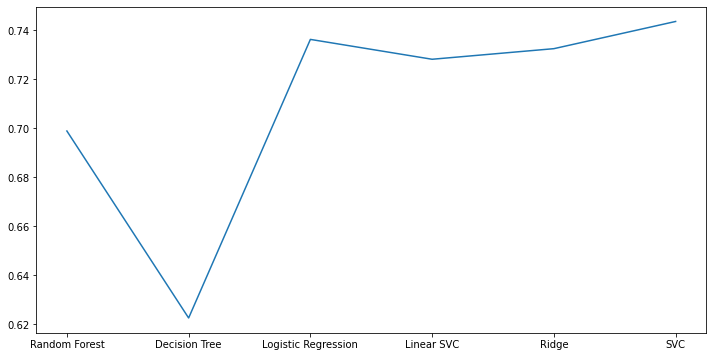

In [100]:
#Line plot of F1 score vs Model
import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(y=scores,x=names)

In [101]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
#Function to preprocess for BERT
def preProcessBert(train_tweets):
    # Creating a raw term frequency matrix
    x_train=preProcessTweets(train_tweets)
    
    input_ids=[]
    attention_masks=[]
    
    #Input ID and Attention mask for BERT Encoder
    for sent in x_train:
        bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids=np.array(input_ids)
    attention_masks=np.array(attention_masks)
    
    return input_ids,attention_masks

In [103]:
#Preprocess the data for BERT
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
test_tweets=pd.read_csv('../input/nlp-getting-started/test.csv')

train_input_ids,train_attention_masks=preProcessBert(train_tweets)
y_train = train_tweets['target'].values

test_input_ids,test_attention_masks=preProcessBert(test_tweets)

train_inp,val_inp,y_train_eval,y_test_eval,train_mask,val_mask=train_test_split(train_input_ids,y_train,train_attention_masks,test_size=0.2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [105]:
#BERT model
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_76 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [106]:
history=bert_model.fit([train_inp,train_mask],y_train_eval,
                       batch_size=32,epochs=30,
                       validation_data=([val_inp,val_mask],y_test_eval),
                       callbacks=checkpoint)


Epoch 1/30
191/191 [==============================] - 78s 304ms/step - loss: 0.5320 - accuracy: 0.7382 - val_loss: 0.4447 - val_accuracy: 0.8155
Epoch 2/30
191/191 [==============================] - 55s 287ms/step - loss: 0.3615 - accuracy: 0.8505 - val_loss: 0.4235 - val_accuracy: 0.8214
Epoch 3/30
191/191 [==============================] - 55s 286ms/step - loss: 0.2690 - accuracy: 0.9025 - val_loss: 0.4603 - val_accuracy: 0.8194
Epoch 4/30
191/191 [==============================] - 55s 286ms/step - loss: 0.1842 - accuracy: 0.9362 - val_loss: 0.5312 - val_accuracy: 0.8240
Epoch 5/30
191/191 [==============================] - 55s 288ms/step - loss: 0.1513 - accuracy: 0.9464 - val_loss: 0.5153 - val_accuracy: 0.8155
Epoch 6/30
191/191 [==============================] - 55s 286ms/step - loss: 0.1036 - accuracy: 0.9669 - val_loss: 0.6396 - val_accuracy: 0.8017
Epoch 7/30
191/191 [==============================] - 55s 286ms/step - loss: 0.0848 - accuracy: 0.9672 - val_loss: 0.7595 - val_ac

In [107]:
y_pred_test = np.array(bert_model.predict([val_inp,val_mask],batch_size=32).logits.argmax(axis=1))
y_pred_train = np.array(bert_model.predict([train_inp,train_mask],batch_size=32).logits.argmax(axis=1))

names.append('BERT')
train_acc.append(accuracy_score(y_train_eval,y_pred_train))
test_acc.append(accuracy_score(y_test_eval,y_pred_test))
scores.append(f1_score(y_test_eval,y_pred_test))

print(f1_score(y_test_eval,y_pred_test))

0.7844690966719493


<AxesSubplot:>

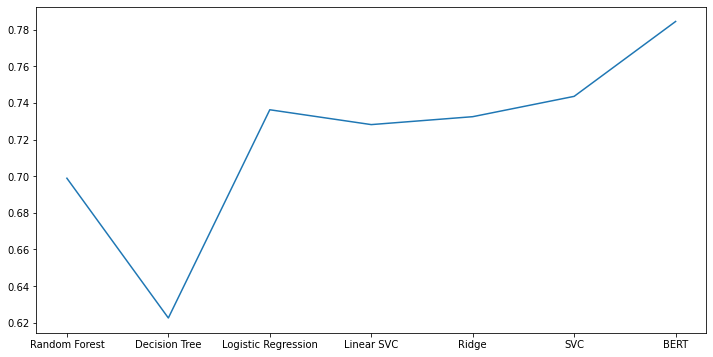

In [108]:
plt.figure(figsize=(12,6))
sns.lineplot(y=scores,x=names)

In [109]:
print(train_acc)
print(test_acc)
print(scores)

[0.9870279146141215, 0.9875205254515599, 0.8604269293924466, 0.8673234811165845, 0.854679802955665, 0.9142857142857143, 0.9863711001642036]
[0.7583716349310571, 0.6743269862114248, 0.7859487852921865, 0.7754432042022325, 0.7846355876559422, 0.7971109652002626, 0.8214051214707814]
[0.6988543371522095, 0.6225266362252664, 0.7362459546925567, 0.7281399046104928, 0.732463295269168, 0.7435684647302905, 0.7844690966719493]


In [110]:
#Function to preprocess for Word2Vec
def word2vect(x_train):
    documents = [text.split() for text in x_train] 
    max_length=max([len(text) for text in documents])
    embedding_dim=300
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=embedding_dim,window=4,min_count=5,workers=8)
    w2v_model.build_vocab(documents)
    w2v_model.train(documents,total_examples=len(documents),epochs=32)
    print(w2v_model.wv.most_similar("fire"))
    

    #print(embedding_matrix.shape)
    return w2v_model,embedding_dim,max_length


In [111]:
#Preprocess the data for Word2Vec
train_tweets=pd.read_csv('../input/nlp-getting-started/train.csv')
test_tweets=pd.read_csv('../input/nlp-getting-started/test.csv')
x_train=preProcessTweets(train_tweets)
y_train = train_tweets['target'].values
x_test=preProcessTweets(test_tweets)

x_train_eval,x_test_eval,y_train_eval,y_test_eval=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

w2v_model,embedding_dim,max_length = word2vect(x_train_eval)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_eval)
vocab_size = len(tokenizer.word_index) + 1

#Creating embedding matrix by comparing words in Tokenizer against similar words in word2vec model
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

[('bush', 0.9205121397972107), ('wild', 0.9166786074638367), ('river', 0.8789862394332886), ('forest', 0.8660890460014343), ('firefighter', 0.8575616478919983), ('rocky', 0.853635847568512), ('rising', 0.8520213961601257), ('acre', 0.8459470272064209), ('caught', 0.8415344953536987), ('annihilation', 0.8396666646003723)]


In [112]:
#Vocabulary in wor2vec model
vocab=w2v_model.wv.index_to_key

#Padding input sequences
x_train_eval = pad_sequences(tokenizer.texts_to_sequences(x_train_eval), maxlen=max_length)
x_test_eval = pad_sequences(tokenizer.texts_to_sequences(x_test_eval), maxlen=max_length)           
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_length) 

In [113]:
#Word2vec model
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           3566700   
_________________________________________________________________
dropout_77 (Dropout)         (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,609,357
Trainable params: 42,657
Non-trainable params: 3,566,700
_________________________________________________________________


In [114]:
#Code to get F1 score during model fit
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [115]:
model.compile(loss='binary_crossentropy',
              optimizer='Adamax',
              metrics=[get_f1])
epoch=10
history = model.fit(x_train_eval, y_train_eval,
                    batch_size=32,
                    epochs=epoch,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
153/153 [==============================] - 23s 129ms/step - loss: 0.5943 - get_f1: 0.6291 - val_loss: 0.5161 - val_get_f1: 0.6729
Epoch 2/10
153/153 [==============================] - 19s 127ms/step - loss: 0.4997 - get_f1: 0.6734 - val_loss: 0.5019 - val_get_f1: 0.6833
Epoch 3/10
153/153 [==============================] - 20s 131ms/step - loss: 0.4899 - get_f1: 0.6872 - val_loss: 0.4969 - val_get_f1: 0.6878
Epoch 4/10
153/153 [==============================] - 19s 126ms/step - loss: 0.4933 - get_f1: 0.6941 - val_loss: 0.4897 - val_get_f1: 0.6884
Epoch 5/10
153/153 [==============================] - 20s 130ms/step - loss: 0.4770 - get_f1: 0.7065 - val_loss: 0.4864 - val_get_f1: 0.7117
Epoch 6/10
153/153 [==============================] - 20s 130ms/step - loss: 0.4820 - get_f1: 0.6927 - val_loss: 0.4876 - val_get_f1: 0.7141
Epoch 7/10
153/153 [==============================] - 20s 128ms/step - loss: 0.4607 - get_f1: 0.7205 - val_loss: 0.4851 - val_get_f1: 0.6984
Epoch 8/10
15

In [116]:
y_pred_test = model.predict_classes(x_test_eval)
y_pred_train = model.predict_classes(x_train_eval)

names.append('Word2Vec_LSTM')
train_acc.append(accuracy_score(y_train_eval,y_pred_train))
test_acc.append(accuracy_score(y_test_eval,y_pred_test))
scores.append(f1_score(y_test_eval,y_pred_test))

print(f1_score(y_test_eval,y_pred_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7001675041876048


Text(0.5, 1.0, 'Accuracy')

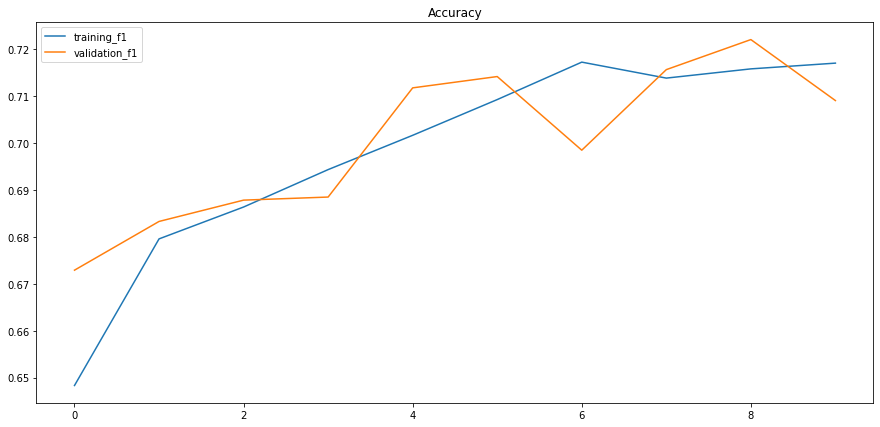

In [117]:
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(epoch), history.history['get_f1'])
plt.plot(range(epoch), history.history['val_get_f1'])
plt.legend(['training_f1', 'validation_f1'])
plt.title('Accuracy')

In [118]:
print(train_acc)
print(test_acc)
print(scores)

[0.9870279146141215, 0.9875205254515599, 0.8604269293924466, 0.8673234811165845, 0.854679802955665, 0.9142857142857143, 0.9863711001642036, 0.7888341543513957]
[0.7583716349310571, 0.6743269862114248, 0.7859487852921865, 0.7754432042022325, 0.7846355876559422, 0.7971109652002626, 0.8214051214707814, 0.7649376231122784]
[0.6988543371522095, 0.6225266362252664, 0.7362459546925567, 0.7281399046104928, 0.732463295269168, 0.7435684647302905, 0.7844690966719493, 0.7001675041876048]


<AxesSubplot:>

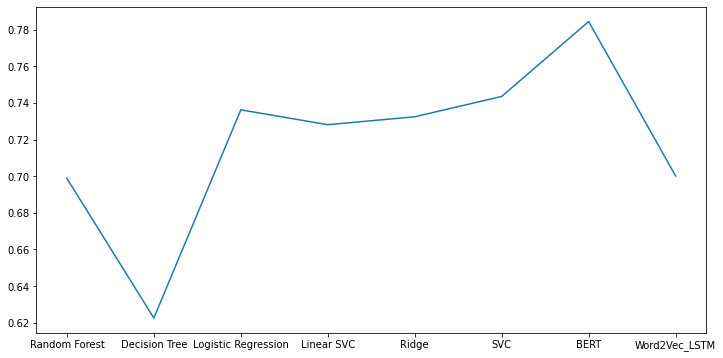

In [119]:
plt.figure(figsize=(12,6))
sns.lineplot(y=scores,x=names)

In [120]:
tweet_dataframe=pd.read_csv('../input/nlp-getting-started/test.csv')
df=pd.DataFrame(test_tweets['id'],columns=['id'])
df['target']=y_pred
df.to_csv('./submission25.csv', index=False)

## **Summary of all models and corresponding scores (in ascending order)**

|Sno.|Model|Vectorizer|Ngram|SVD|Train Accuracy|Test Accuracy|Test F1 Score|
|:-|:-|:-|:-|:-|:-|:-|:-|
|1|BERT|-|No|No|0.965024631|0.812212738|0.777258567|
|2|SVC|Count|1|Yes|0.914285714|0.797110965|0.743568465|
|3|SVC|Count|2|Yes|0.897701149|0.796454366|0.740802676|
|4|Logistic Regression|Count|2|Yes|0.85862069|0.788575181|0.739482201|
|5|Logistic Regression|Count|1|Yes|0.860426929|0.785948785|0.736245955|
|6|Ridge|Count|1|Yes|0.854679803|0.784635588|0.732463295|
|7|Support Vector|TFIDF|1|Yes|0.858128079|0.782009192|0.731825525|
|8|SVC|TFIDF|1|Yes|0.914285714|0.787918582|0.729707113|
|9|Support Vector|TFIDF|2|Yes|0.848275862|0.781352594|0.729488221|
|10|Ridge|TFIDF|1|Yes|0.85270936|0.78332239|0.728171334|
|11|Support Vector|Count|1|Yes|0.867323481|0.775443204|0.728139905|
|12|Support Vector|Count|2|Yes|0.865517241|0.774130007|0.725677831|
|13|Ridge|Count|2|Yes|0.851067323|0.782009192|0.725619835|
|14|Ridge|TFIDF|2|Yes|0.845320197|0.780695995|0.721666667|
|15|SVC|TFIDF|2|Yes|0.8863711|0.782665791|0.721145746|
|16|Logistic Regression|TFIDF|1|Yes|0.837931034|0.785948785|0.719449225|
|17|LSTM|word2vec|No|No|0.786863711|0.768220617|0.712306438|
|18|Logistic Regression|TFIDF|2|Yes|0.827422003|0.787261983|0.708108108|
|19|Random Forest|Count|1|Yes|0.987027915|0.758371635|0.698854337|
|20|Random Forest|TFIDF|1|Yes|0.987027915|0.768877216|0.69707401|
|21|Random Forest|TFIDF|2|Yes|0.987520525|0.766250821|0.696245734|
|22|Random Forest|Count|2|Yes|0.987520525|0.757058437|0.694214876|
|23|Decision Tree|TFIDF|2|Yes|0.987520525|0.680892974|0.624420402|
|24|Decision Tree|Count|2|Yes|0.987520525|0.681549573|0.623739333|
|25|Decision Tree|Count|1|Yes|0.987520525|0.674326986|0.622526636|
|26|Decision Tree|TFIDF|1|Yes|0.987520525|0.645436638|0.6|